# Linear Regression From Scratch 

This document is the full implementation of the **Linear Regression** using only **NumPy**, lets get started :
### **Core imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

- **numpy** for vector and matrix manipulation
- **matplotlib** for plotting important diagnostics and visualizations 

### Options and Utils 

In [2]:
np.set_printoptions(precision=4, suppress=True, linewidth=100)

In [3]:
def is_invertible(A):
    return np.linalg.matrix_rank(A) == A.shape[0]

## **Generating data**
---
Before implementing the core functionalities of Linear Regression, we create a function that generate dummy data where we controle the number of **observations** \$n$ and variables  $p$ , while also knowing the true forms of our **coefficients** β̂ which will be useful to see how accurate our estimates to the generate data

In [4]:
def generate_dummy_data(n=10000, p=3, noise_std=1.0, seed=420):
    np.random.seed(seed)
    X_raw = np.random.randn(n, p - 1)  

- Generating our features matrix  `X_raw`

In [5]:
def generate_dummy_data(n=10000, p=3, noise_std=1.0, seed=420):
    np.random.seed(seed)

    X_raw = np.random.randn(n, p - 1) 
    
    intercept = np.ones((n, 1))  

    X = np.hstack([intercept, X_raw])

- Generating our intercept vector which can be constant non zero values
- Horizontally stacking the features matrix `X_raw` and the intercept vector to obtain our **Design matrix** \$X$

In [6]:
def generate_dummy_data(n=10000, p=3, noise_std=1.0, seed=420):
    np.random.seed(seed)

    X_raw = np.random.randn(
        n, p - 1
    ) 
    intercept = np.ones((n, 1)) 

    X = np.hstack([intercept, X_raw])

    beta_true = np.array([3] + [2] * (p - 1)) 
    
    noise = np.random.randn(n) * noise_std  
    
    y = X @ beta_true + noise 
    
    return X, y, beta_true, noise

- `beta_true` is an array that contains the true intercept $\beta_{0}=3$ $\beta_{p-1}=2$
    - For testing purposes we make the assumption that all the coefficients are equal
- `noise` is the irreducible error, the variance we get for modeling data into a linear equation
- `y` is the true predicted value which is also the **true regression line** that we will estimate later

## **Phase 1 : Core Math & Implementation**

### Ordinary Least Sqaures 
---
The **OLS** method is the core concept to fit a regression model done by calculting the **closed-form** (estimate) of the model coefficients $\beta=(X^TX)^{-1}  X^T Y$

In [7]:
def ols_estimate(X, Y):
    X_transpose = X.T  
    gram_matrix = X_transpose @ X
    if not is_invertible(gram_matrix):
        raise ValueError(f"The gram matrix with shape{gram_matrix.shape} is sningular")

Before calculting the estimated coefficient matrix $\hat{\beta}$, we need :
- Transpose of the **Design Matrix** $X$
- Gram matrix which is the inverse of $X^TX$

In [8]:
def ols_estimate(X, Y):
    
    X_transpose = X.T  
    
    gram_matrix = X_transpose @ X
    
    if not is_invertible(gram_matrix):
        raise ValueError(f"The gram matrix with shape{gram_matrix.shape} is sningular")
        
    beta_hat = (np.linalg.inv(gram_matrix) @ X_transpose @ Y)  
    
    return beta_hat, gram_matrix 

- Returning `beta_hat` which is the estimated coefficient the `gram_matrix` which gonan be useful for future calculations

In [9]:
X,Y,beta_true,noise = generate_dummy_data()
beta_hat_ols,gram_matrix = ols_estimate(X,Y)
print("This is the estimated Coefficient are : \n",beta_hat_ols)

This is the estimated Coefficient are : 
 [2.9851 1.9937 2.006 ]


In [10]:
print(f"This is the Gram matrix \n{gram_matrix}")
gram_matrix.shape

This is the Gram matrix 
[[10000.        13.433    -61.6067]
 [   13.433   9958.9931    15.7982]
 [  -61.6067    15.7982  9877.0084]]


(3, 3)

- The Gram matrix shows the relati

### Gradient Descent
---
While the **OLS** method is simple and work great but when dealing with large amount of observations $n$ and variables $p$ taking the inverse of a matrix gonne be so costly.

Thats where **Gradient Descent** comes its an **iterative** algorithm that adjuest the estimation each iteration till it arrives to the *almost* correct one 

In [11]:
def gradient_descent(y, X, alpha, batch_size, n, p, n_iters):
    y = y.reshape(-1, 1)
    beta_hat = np.zeros((p, 1))

- The **Gradient Descent** function takes in `alpha` and `batch_size` which are called hyperparameters
    - **Batch size** is how much data we use each update
    - **alpha** is the Learning rate $->$ the step size 
- `n_iters` is times we update till we stop 
- `y.reshape(-1,1)` is to transform the response into a column vector with $n \times 1$

In [12]:
def gradient_descent(y, X, alpha, batch_size, n, p, n_iters):
    y = y.reshape(-1, 1)
    beta_hat = np.zeros((p, 1))
    
    for i in range(n_iters):
        idx = np.random.choice(n, size=batch_size, replace=False)
        Xb = X[idx]
        yb = y[idx].reshape(-1, 1)
        y_hat = Xb @ beta_hat
        RSS = y_hat - yb
        gradient_mse = (Xb.T @ RSS) / batch_size
        beta_hat_new = beta_hat - alpha * gradient_mse

        if np.linalg.norm(beta_hat_new - beta_hat) < 1e-6:
            break
            
        beta_hat = beta_hat_new
    return beta_hat

- Both `Xb` and `yb` are randomly sampled pair of observation-response
- `gradient_mse` is the mean squared error that the algorithm calculate each time to get closer to the correct estimates
- `beta_hat_new` is the updated estimate after each step
- `break` if the difference between the old estimate and the new estimate is small and not significant anymore

In [13]:
X,Y,beta_true,noise = generate_dummy_data()
beta_hat_GD =gradient_descent(Y,X,0.01,500,10000,3,50000)
print("The estimated coefficients using Gradient Descent are : \n",beta_hat_GD)

beta_hat_ols,gram_matrix = ols_estimate(X,Y)
print("\nThis is the estimated Coefficient using OLS are : \n",beta_hat_ols)

The estimated coefficients using Gradient Descent are : 
 [[2.9896]
 [1.9921]
 [2.008 ]]

This is the estimated Coefficient using OLS are : 
 [2.9851 1.9937 2.006 ]


- As you can notice both methods produced the same results 

### Measn Squared Error (MSE)
---
As the name imply its the sum (mean) squared of the difference between the **true prediction** and the **estimate prediction** 

In [14]:
def mean_squared_error(y, y_hat, p, n):
    residuals = y - y_hat
    RSS = np.sum(residuals**2)

- We calculate `RSS` the **residual squared sum** 

In [15]:
def mean_squared_error(y, y_hat, p, n):

    residuals = y - y_hat
    RSS = np.sum(residuals**2)

    if n - p <= 0:
        raise ValueError(f"Degrees of freedom (n-p) must be >0, got n={n},p={p}")
    MSE = RSS / (n - p)
    
    return MSE, RSS

- Deviding by the Degrees of freedom to make it unbaised  to get the **Mean Squared Error** 
- Returning both `MSE` and `RSS` for future use 

### **Prediction**
---
After calculating the estimates for the coefficients $\beta$, we can create this prediction function

In [16]:
def predict(X, beta_hat):
    
    y_hat = X @ beta_hat
    
    return y_hat

- It simply multiply the **Design matrix** with estimated coefficients vector $\beta$
- Returns the estimated prediction $\hat{y}$

In [17]:
Y_hat = predict(X,beta_hat_ols)
MSE,RSS = mean_squared_error(Y,Y_hat,3,10000)
residuals = Y-Y_hat

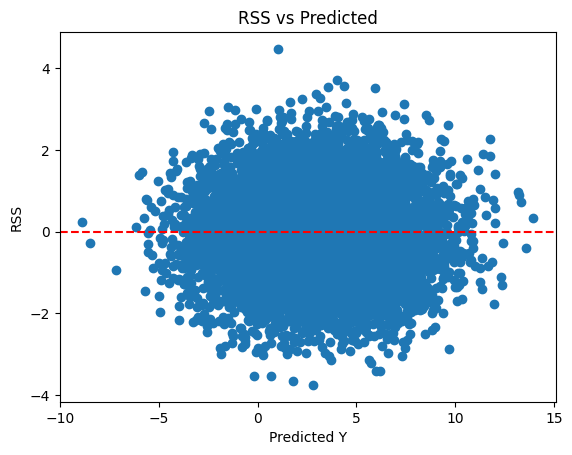

In [18]:
plt.scatter(Y_hat,residuals)
plt.axhline(0,color='red',linestyle="--")
plt.xlabel("Predicted Y")
plt.ylabel("RSS")
plt.title("RSS vs Predicted")
plt.show();



### Phase 1 Conclusion:

- Both **OLS** and **Gradient Descent** achive the same goal while both using different approaches with each one having it use cases and pros and cons (more details in the  githu repository)

## **Phase 2: Statistical Inference**
---

This Phase we asses the estimated **coefficients** (parameters) $\hat{\beta}$, to see how close our estimated values to the true ones: 
- Standard Error
- Confidence interval
- F-test 

### **Standard Error for $\hat{\beta}$**
---

The standard Error is calculated by square root of the **variance** in the estimated **coefficient** $\hat{\beta}$, which can be derived from the closed form of $\beta$ (Check [GitHub](https://github.com/0xHadyy/Linear-Regression-Scratch) repository for derivations) 

In [19]:
def standard_error_beta(mse, gram_matrix):
    
    if not is_invertible(gram_matrix):
        raise ValueError("The Gram matrix is signular")

    inv_gram_matrix = np.linalg.inv(gram_matrix)
    
    beta_hat_variance = (mse * inv_gram_matrix)  # The diagonal represent the variances, while off-diagonal are the covarianec

- To calculate the variance in the estimated **coefficient**, we need both the **MSE**(sample standard deviation) and the **Gram matrix**
- `beta_hat_variance` is a square matrix with its diagonal representing the **variances**, while off-diagonal are the **covariances**

In [20]:
def standard_error_beta(mse, gram_matrix):
    
    if not is_invertible(gram_matrix):
        raise ValueError("The Gram matrix is signular")

    inv_gram_matrix = np.linalg.inv(gram_matrix)
    
    beta_hat_variance = (mse * inv_gram_matrix) 

    beta_hat_standard_error = np.sqrt(np.diag(beta_hat_variance)) 
    
    return beta_hat_variance, beta_hat_standard_error

- `beta_standard_error` is the square root onl the **diagonal** elements of the `beta_hat_variance` matrix

In [21]:
beta_var, se_beta = standard_error_beta(MSE,gram_matrix)
print(se_beta)

[0.0102 0.0102 0.0102]


- As you can notice the **standard error** equal across all the coefficients $\hat{\beta}$, cause all our coefficients are equal you can test by randomize the values and u will get other different results across all  parameters

### **Confidence interval for Estimated $\beta$**
---

After calculting the **Standard error** in the estimated coefficient vector $SE(\hat{\beta})$, we can use it to construct a **Confidence interval** for $\hat{\beta}$

In [22]:
def confidence_interval_beta(beta_hat, standard_error, df, t_critical_95):
    closest_df = min(t_critical_95, key=lambda x: abs(x - df))
    t_value = t_critical_95[closest_df]

- Following the  formula of the **confidence interval**, First we need to calculate:
    - `t-value` for the closest or equal **Degree of freedom**
    - `t_critical_95` is a python dictionary that contains all value for a $95\%$ confidence $\to$ $\alpha=0.05$

In [23]:
t_table = {
    1: 12.706,
    2: 4.303,
    3: 3.182,
    4: 2.776,
    5: 2.571,
    6: 2.447,
    7: 2.365,
    8: 2.306,
    9: 2.262,
    10: 2.228,
    11: 2.201,
    12: 2.179,
    13: 2.160,
    14: 2.145,
    15: 2.131,
    16: 2.120,
    17: 2.110,
    18: 2.101,
    19: 2.093,
    20: 2.086,
    21: 2.080,
    22: 2.074,
    23: 2.069,
    24: 2.064,
    25: 2.060,
    26: 2.056,
    27: 2.052,
    28: 2.048,
    29: 2.045,
    30: 2.042,
    40: 2.021,
    60: 2.000,
    120: 1.980,
    float("inf"): 1.960,  # Z‐value approximation
}

In [24]:
def confidence_interval_beta(beta_hat, standard_error, df, t_critical_95):
    closest_df = min(t_critical_95, key=lambda x: abs(x - df))
    t_value = t_critical_95[closest_df]
    upper_bound = beta_hat + (t_value * standard_error)
    lower_bound = beta_hat - (t_value * standard_error)
    confidence_interval = np.stack((lower_bound, upper_bound))
    return confidence_interval

In [25]:
beta_CI= confidence_interval_beta(beta_hat_ols,se_beta,3,t_table)
print(beta_CI.T)

[[2.9528 3.0174]
 [1.9614 2.0261]
 [1.9735 2.0385]]


- This rows of this matrix are the confidence intervals for each coefficient

### **F-statistic** :
---
- Also know as **f-test** its a way to test the **hypothesis** that there is no relationship between the **respnse** $Y$ and Predictors $X$, and that fitting the **Linear regression** equation didn't explain the variance in the  original data

In [26]:
def f_statistic(RSS, y, p, n):
    
    y_mean = np.mean(y)
    
    TSS = np.sum((y - y_mean) ** 2)
    if p == 0:
        raise ValueError("invalid Features number")
        
    numerator = (TSS - RSS) / p
    
    denominator = RSS / (n - p - 1)
    
    f_test = numerator / denominator

    return f_test, TSS

- The `f_test` is the amount of variance our regression explained
- if it equal to $\sigma^2$ means that our null hypothesis is true and there is no relationship between the response and predictors
<br>Note : Look up **F-Table**

In [27]:
f_score, TSS = f_statistic(RSS,Y,3,10000)
print(f"the f-score is : {f_score:.4f}")

the f-score is : 25704.5270


## **Phase 3 : Model Evaluation**
---
Discussing methods and ways to evaluate how well our model fits the data

1. Residual Standard Error
2. R-Squared
3. Prediction interval
4. F-test

### **Residual Standard Error** 
--- 

It estimates the standard deviation of *regression error* which is the irreducible error $\epsilon$

In [28]:
def residual_standard_error(RSS, p, n):
    if n - p - 1 <= 0:
        raise ValueError("Degrees of freedom <= 0 Check n and p")
    RSE = np.sqrt(RSS / (n - p - 1))
    return RSE

- Lower values of `RSE` indicate tighter fit and less unexplained varriability which imply that our regression explains most of it
- Higher values of `RSE` indicate a poor fit

In [29]:
RSE = residual_standard_error(RSS,3,10000)
print(f"the Residual Standard Error for our model is {RSE:.4f}")

the Residual Standard Error for our model is 1.0151


### **R-Squared**
--- 
Its an alternative measure of fit, that is propotional to **variance** in $Y$ including both `RSS` and `TSS`

In [30]:
def r_squared(RSS, TSS):
    r_squared = 1 - (RSS / TSS)
    if not (0 <= r_squared <= 1):
        raise ValueError("Error happened while computing R_sqaured")
    return r_squared

In [31]:
R2= r_squared(RSS,TSS)
print(f"The R-Squared of our odel is {R2:.4f}")

The R-Squared of our odel is 0.8852


- The closer to $1$ means that the model explain much of the **variablity** in the origianl data
-  Closer to $0$ indicates that either the model doesn't fit well or the **irreducible** error $\epsilon$ is too high or both 

### **Standard Error Response** 
---

Before calculating the **Confidence interval** for the **Mean Response** and **Prediction interval** for a **New Observation**

In [32]:
def standard_error_reponse(X0, MSE, gram_matrix,p):
    
    if gram_matrix.shape != (p, p):
        raise ValueError(f"Gram matrix shape {gram_matrix.shape}")
        
    if MSE < 0:
        raise ValueError("MSE is zero or negative")
        
    if not is_invertible(gram_matrix):
        raise ValueError("The gram fucntion is singular")
        
    inv_gram_matrix = np.linalg.inv(gram_matrix)
    X0_transpose = X0.T

- Before calculating the Standard Error $SE()$ in new reponse $Y_{0}$ and in the predicted response $Y_{0} - \hat{Y_{0}}$
- We perform some checks on the value of $MSE$ and the invertibility  of the  $\text{Gram Matrix}$ and calculating the **Transpose** of the new unseen predictor $X_{0}$

In [33]:
def standard_error_response(X0, MSE, gram_matrix,p):
    
    if gram_matrix.shape != (p, p):
        raise ValueError(f"Gram matrix shape {gram_matrix.shape}")
        
    if MSE < 0:
        raise ValueError("MSE is zero or negative")
        
    if not is_invertible(gram_matrix):
        raise ValueError("The gram fucntion is singular")
        
    inv_gram_matrix = np.linalg.inv(gram_matrix)
    X0_transpose = X0.T
    
    var_Y0 = MSE * (X0_transpose @ inv_gram_matrix @ X0) 
    var_Y0_hat = MSE * (1 + X0_transpose @ inv_gram_matrix @ X0)
    
    se_Y0_hat = np.sqrt(var_Y0_hat)
    se_Y0 = np.sqrt(var_Y0)
    
    return var_Y0, se_Y0, var_Y0_hat, se_Y0_hat

- Following the formula of $\text{Variance}$ for $Y_{0}$ and $Y_{0}-\hat{Y_{0}}$
- Inserting the square root $\to$ We get the **Standard Error** in both the new unseen **Response** and the error in the predicted new unseen response

In [34]:
X0 = np.random.normal(size=(3,)) 

Y0 = X0 @ beta_true + noise 
print(f"the new vector of unseen responses are : {Y0}")

the new vector of unseen responses are : [-2.6329 -2.5631 -0.6166 ... -3.4306 -3.1839 -2.9512]


- Generating new unseen Predictor $X_0$ and $Y_0$

In [35]:
Y0_hat = X0@ beta_hat_ols.flatten()
print(f"The new predicted unseen response = {Y0_hat:.4f}")

The new predicted unseen response = -2.1222


In [36]:
var_Y0,se_Y0,var_Y0_hat, se_Y0_hat = standard_error_response(X0,MSE,gram_matrix,3)
print(f"The standard error in mean response is {se_Y0:.4f}")
print(f"The standard error in a unseen predicted response is {se_Y0_hat:.4f}")

The standard error in mean response is 0.0257
The standard error in a unseen predicted response is 1.0154


In [37]:
X0


array([-0.8412,  1.7797, -1.5749])

In [38]:
Y0_hat

np.float64(-2.1221906066947156)

### **Confidence Interval for Mean Response $Y_{0}$**
---

Here we estimate the interval which the **True meann** for a new response $Y_{0}$ will fall on, Simply what is the average value a new response will most likely fall

In [39]:
def confidence_interval_mean_response(Y0_hat, se_Y0, df, t_table):
    
    closest_df = min(t_table, key=lambda x: abs(x - df))
    t_value = t_table[closest_df]
    
    upper_bound = Y0_hat + (t_value * se_Y0)
    lower_bound = Y0_hat - (t_value * se_Y0)
    
    response_mean_cl = np.stack((lower_bound, upper_bound))
    
    return response_mean_cl

- Since its a sample data we will use the **t-score** again to calculate the interval upper and lower bound 

In [40]:
mean_CI = confidence_interval_mean_response(Y0_hat,se_Y0_hat,3,t_table)
print(f"The confidence interval for mean response : {mean_CI}")

The confidence interval for mean response : [-5.3531  1.1087]


- This is a $95\%$ confidence interval for the mean response $\hat{Y_0}$
- In simpler terms we expect the average value of $\hat{Y_0}$ with $95\%$ to be in that interval

### **Prediction Interval for New Response $Y_0$**
---

Estimate the range which a **single new** $Y_0$ drawn at $X_0$ willl fall, taking into account the model + error term of it, Its not the average unlike the **Confidence interval for mean response** 

In [41]:
def prediction_interval_reponse(Y0_hat,se_Y0_hat,MSE,df,t_table):
    closest_df = min(t_table, key = lambda x: abs(x-df))
    t_value = t_table[closest_df]

    pred_se = np.sqrt(se_Y0_hat**2+MSE)

    upper_bound = Y0_hat + (t_value*pred_se)
    lower_bound = Y0_hat - (t_value*pred_se)

    prediction_interval = np.stack((lower_bound,upper_bound))
    
    return prediction_interval

In [42]:
pre_interval = prediction_interval_reponse(Y0_hat, se_Y0_hat,MSE,3,t_table)
print(f"This is the Prediction interval for new response {pre_interval}")

This is the Prediction interval for new response [-6.6906  2.4462]


- As you can notice the prediction interval is always wider than the confidence interval cause it takes into account the error term which represented by **MSE**
- Reminder that `MSE` is the estimated value for $\sigma^2$

# **Real Data Applied**
---

- Unlike the `Dummy data` we used when applying the core concepts of **Linear Regression**
- Using Real world Data will help to expand this implementation to the next level by :
    - Assumptions & Diagnostics Testing
    - Handling **Outliers**
    - Identfying **High Leverage Points**
    - Dealing with **Multicolinearity**

In [78]:
import pandas as pd

- For more advance diagnostics and realistic application of the Linear Regression model we built so far we importing **pands** which is a powerful library for data manipulation and analysis
- in the `Data set` Folder we gonna load `College.csv` which is data  collected of american colleges including the `Application` they get each year , `Acceptance`,`PhD`, `Books` etc... 

In [79]:
Data = pd.read_csv('../Data-Set/College.csv')
Data

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,Worcester State College,No,2197,1515,543,4,26,3089,2029,6797,3900,500,1200,60,60,21.0,14,4469,40
773,Xavier University,Yes,1959,1805,695,24,47,2849,1107,11520,4960,600,1250,73,75,13.3,31,9189,83
774,Xavier University of Louisiana,Yes,2097,1915,695,34,61,2793,166,6900,4200,617,781,67,75,14.4,20,8323,49
775,Yale University,Yes,10705,2453,1317,95,99,5217,83,19840,6510,630,2115,96,96,5.8,49,40386,99


- We gonna be building a simple Multiple Linear Regression off this data


## Goal
--- 
- Predict the **acceptance rate** of the college using :
    - Whether College is **private** or **Public**
    - **Number of applications** 
    - **Out-of-State tuition**  

## Design Matrix
--- 

In [80]:
Data.columns

Index(['Unnamed: 0', 'Private', 'Apps', 'Accept', 'Enroll', 'Top10perc',
       'Top25perc', 'F.Undergrad', 'P.Undergrad', 'Outstate', 'Room.Board',
       'Books', 'Personal', 'PhD', 'Terminal', 'S.F.Ratio', 'perc.alumni',
       'Expend', 'Grad.Rate'],
      dtype='object')

In [164]:
def design_matrix(data_frame):
    for type in data_frame.dtypes:
        print(type)
        if type != ('int64'or 'float64'):
            raise ValueError("Design matrix can't contain non numirical values")
    X_raw = data_frame.to_numpy()
    intercept = np.ones((data_frame.shape[0],1))
    design_matrix = np.hstack([intercept,data_frame])
    return design_matrix

In [165]:
data_frame = Data[['Private','Apps','Outstate']].copy()
data_frame['Private'] = data_frame['Private'].map({'Yes':1,'No':0})
print(data_frame.dtypes)
if data_frame['Private'].dtypes == 'int64':
    print('meow')


Private     int64
Apps        int64
Outstate    int64
dtype: object
meow


In [166]:
design_matrix = design_matrix(data_frame)
design_matrix

int64
int64
int64


array([[    1.,     1.,  1660.,  7440.],
       [    1.,     1.,  2186., 12280.],
       [    1.,     1.,  1428., 11250.],
       ...,
       [    1.,     1.,  2097.,  6900.],
       [    1.,     1., 10705., 19840.],
       [    1.,     1.,  2989.,  4990.]], shape=(777, 4))

- The `design_matrix` function takes on a `data_frame` from pandas and turn it into a numpy array

**Note** : Its better to do it with **Pandas** data frame but for sake for the *From scratch implementation* its transformed into numpy matrix

In [167]:
Y_raw = Data['Accept']/Data['Apps']
Y_raw
acceptance_rate =Y_raw.to_numpy().reshape(-1,1)

- Calculating the `acceptance_rate` for all observations $n$(Colleges) which is the **response** our regression model try to predict
- `reshape(-1,1)` to reshape it into a column vector of true **responses** $Y$
- Which allow us to calculate the estimated coefficients $beta$ for each predictor *Private*, *Number of applications* ,*Out of state tuition*

In [168]:
beta_hat , gram_matrix = ols_estimate(design_matrix,acceptance_rate)
beta_hat

array([[ 0.8687],
       [ 0.0292],
       [-0.    ],
       [-0.    ]])